## Frequency Analysis

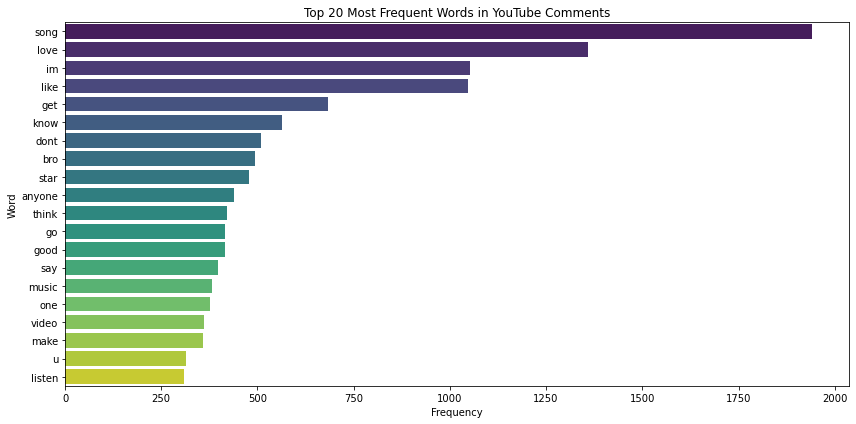

In [2]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Load the processed dataset
df = pd.read_csv("youtube_comments_processed.csv")

# Tokenize all processed comments using split (since it's already preprocessed)
all_words = []
for comment in df['processed_comment'].dropna():
    all_words.extend(comment.split())

# Count word frequencies
word_freq = Counter(all_words)
top_words = word_freq.most_common(20)

# Convert to DataFrame for plotting
freq_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Frequency', y='Word', data=freq_df, palette='viridis')
plt.title("Top 20 Most Frequent Words in YouTube Comments")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

## Sentiment Analysis

In [4]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# One-time setup (run only once)
nltk.download('vader_lexicon')

# Load your cleaned and preprocessed dataset
df = pd.read_csv("youtube_comments_processed.csv")  # Replace with your actual file path

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Compute sentiment scores
df['sentiment_score'] = df['processed_comment'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Classify sentiment
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

# Save results
df.to_csv("youtube_comments_with_sentiment.csv", index=False)

# Summary counts
print(df['sentiment_label'].value_counts())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Sankalp\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Neutral     7860
Positive    4521
Negative    1519
Name: sentiment_label, dtype: int64


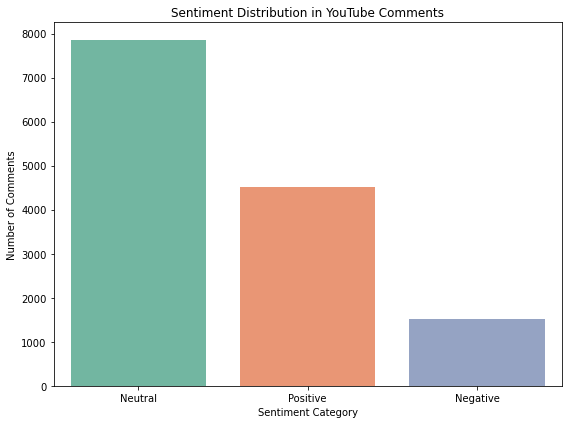

In [5]:
# Count the sentiment labels
sentiment_counts = df['sentiment_label'].value_counts().reset_index()
sentiment_counts.columns = ['Sentiment', 'Count']

# Plotting
plt.figure(figsize=(8, 6))
sns.barplot(data=sentiment_counts, x='Sentiment', y='Count', palette='Set2')
plt.title("Sentiment Distribution in YouTube Comments")
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()

## Topic Modeling

In [8]:
!pip install wordcloud

You should consider upgrading via the 'C:\Users\Sankalp\anaconda3\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [5]:
# Load the sentiment dataset with processed comments
df = pd.read_csv("youtube_comments_with_sentiment.csv")

# Drop any rows with missing processed comments
df = df.dropna(subset=["processed_comment"])

# Use TF-IDF to convert text to vectors
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df["processed_comment"])

# Apply LSA using TruncatedSVD
lsa = TruncatedSVD(n_components=5, random_state=42)
lsa.fit(X)

# Extract terms
terms = vectorizer.get_feature_names_out()


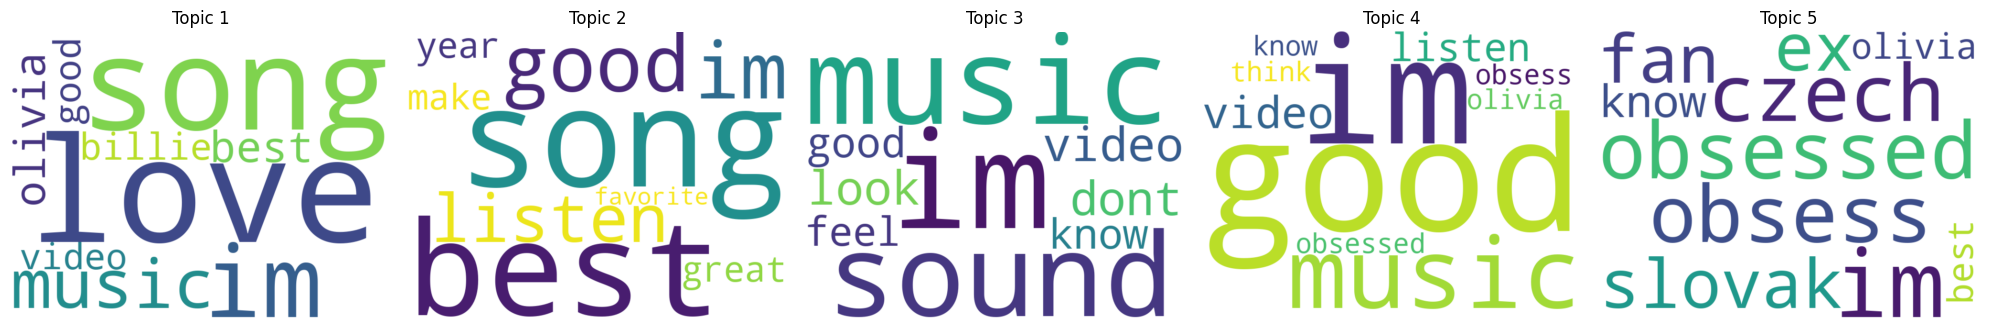

In [8]:
# Create a list of top terms for each topic
topic_words = []
for i, comp in enumerate(lsa.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:10]
    topic_words.append([t[0] for t in sorted_terms])

# Generate word clouds for each topic
fig, axes = plt.subplots(1, 5, figsize=(20, 8), sharex=True)
for i, ax in enumerate(axes):
    wordcloud = WordCloud(width=800, height=600, background_color='white').generate(' '.join(topic_words[i]))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(f"Topic {i+1}")
plt.tight_layout()
plt.show()

## Correlation with Engagement Metrics

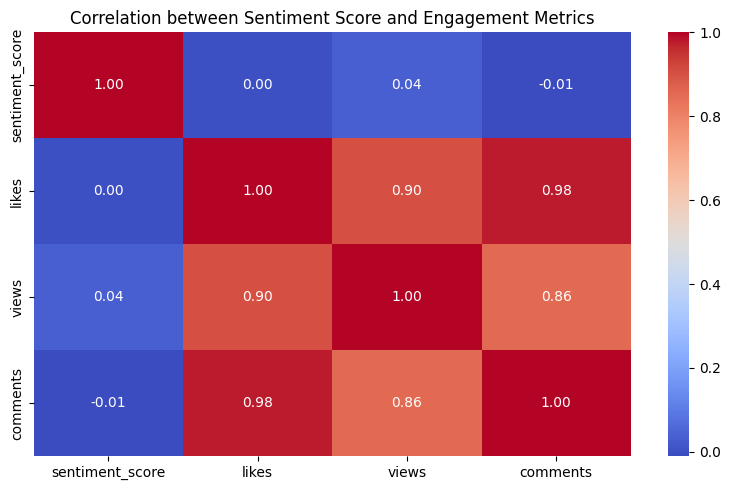

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
engagement_df = df[['sentiment_score', 'likes', 'views', 'comments']].copy()

# Drop rows with missing or invalid data
engagement_df = engagement_df.dropna()

# Calculate correlation matrix
correlation_matrix = engagement_df.corr()

# Plot heatmap of correlations
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Sentiment Score and Engagement Metrics')
plt.tight_layout()
plt.show()

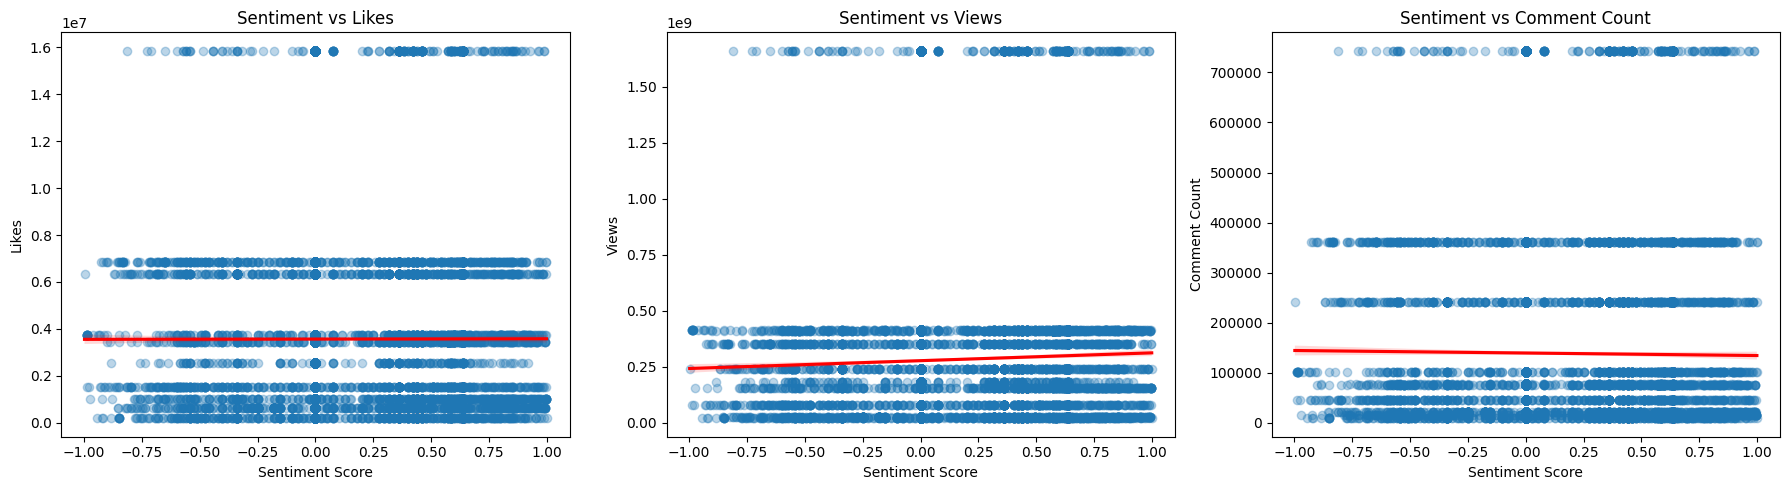

In [14]:
# Regenerate scatter plots using the correct sentiment score column
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sentiment vs Likes
sns.regplot(x='sentiment_score', y='likes', data=df, ax=axes[0], scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
axes[0].set_title('Sentiment vs Likes')
axes[0].set_xlabel('Sentiment Score')
axes[0].set_ylabel('Likes')

# Sentiment vs Views
sns.regplot(x='sentiment_score', y='views', data=df, ax=axes[1], scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
axes[1].set_title('Sentiment vs Views')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Views')

# Sentiment vs Comment Count
sns.regplot(x='sentiment_score', y='comments', data=df, ax=axes[2], scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
axes[2].set_title('Sentiment vs Comment Count')
axes[2].set_xlabel('Sentiment Score')
axes[2].set_ylabel('Comment Count')

plt.tight_layout()
plt.show()


In [18]:
import numpy as np

In [26]:
df = pd.read_csv("youtube_comments_with_sentiment.csv")

C:\Users\Sankalp\AppData\Local\Temp\ipykernel_23688\1450874730.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(data=hourly_ratio, x='hour', y='like_view_ratio', palette='magma')


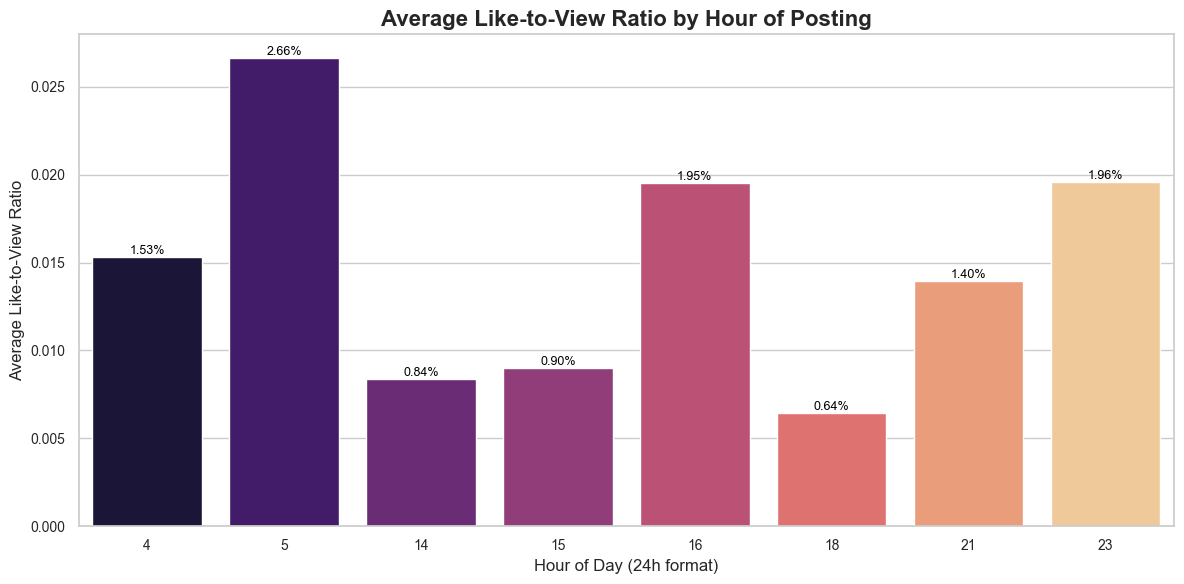

In [22]:
# Rename the correct datetime column and convert to datetime
df['published'] = pd.to_datetime(df['published'], errors='coerce')

# Extract hour and compute Like-to-View ratio
df['hour'] = df['published'].dt.hour
df['like_view_ratio'] = df['likes'] / df['views']
df = df.dropna(subset=['like_view_ratio'])

# Group by hour and calculate the average ratio
hourly_ratio = df.groupby('hour')['like_view_ratio'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
palette = sns.color_palette("magma", as_cmap=True)

bar = sns.barplot(data=hourly_ratio, x='hour', y='like_view_ratio', palette='magma')

plt.title('Average Like-to-View Ratio by Hour of Posting', fontsize=16, weight='bold')
plt.xlabel('Hour of Day (24h format)', fontsize=12)
plt.ylabel('Average Like-to-View Ratio', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Annotate values on bars
for p in bar.patches:
    height = p.get_height()
    bar.annotate(f'{height:.2%}',
                 (p.get_x() + p.get_width() / 2., height),
                 ha='center', va='bottom',
                 fontsize=9, color='black', rotation=0)

plt.tight_layout()
plt.show()

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set visual style
sns.set(style="whitegrid")

# 1. Clean and Prepare the Data
df = df.rename(columns={
    'likes': 'like_count',
    'views': 'view_count',
    'published': 'published_at',
    'sentiment_score': 'compound'
})

# Drop missing values
df = df.dropna(subset=['comment', 'like_count', 'view_count', 'published_at', 'compound'])

# Convert timestamps
df['published_at'] = pd.to_datetime(df['published_at'])
df['publish_hour'] = df['published_at'].dt.hour
df['publish_weekday'] = df['published_at'].dt.day_name()

# Compute like-to-view ratio
df['like_to_view_ratio'] = df['like_count'] / df['view_count']

# Label sentiment
df['sentiment_label'] = df['compound'].apply(
    lambda x: 'positive' if x > 0.2 else ('negative' if x < -0.2 else 'neutral')
)

# Group by sentiment for metrics
sentiment_stats = df.groupby('sentiment_label').agg(
    avg_like_to_view=('like_to_view_ratio', 'mean'),
    avg_comment_length=('comment', lambda x: np.mean([len(c.split()) for c in x])),
    count=('comment', 'count')
).reset_index()

C:\Users\Sankalp\AppData\Local\Temp\ipykernel_23688\1026632643.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_stats, x='sentiment_label', y='avg_like_to_view', palette='Set2')


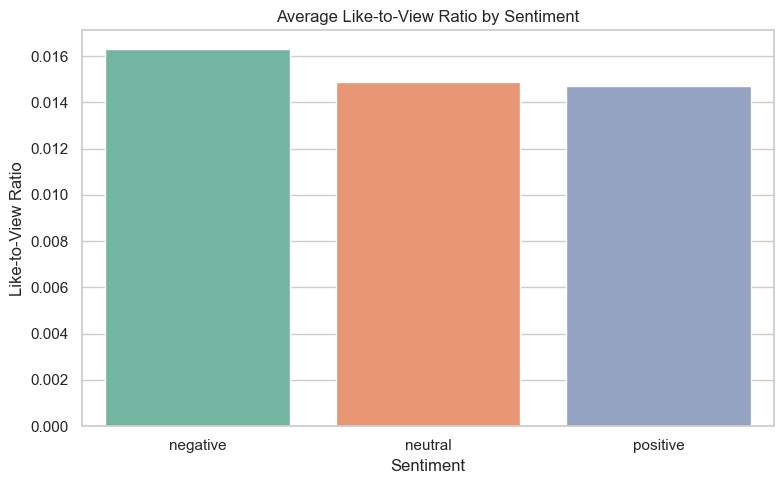

C:\Users\Sankalp\AppData\Local\Temp\ipykernel_23688\1026632643.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_stats, x='sentiment_label', y='avg_comment_length', palette='Set1')


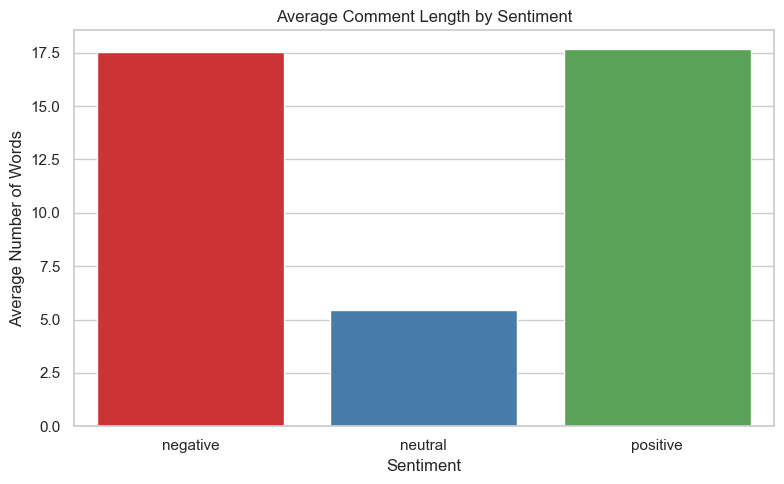

C:\Users\Sankalp\AppData\Local\Temp\ipykernel_23688\1026632643.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_stats, x='sentiment_label', y='count', palette='pastel')


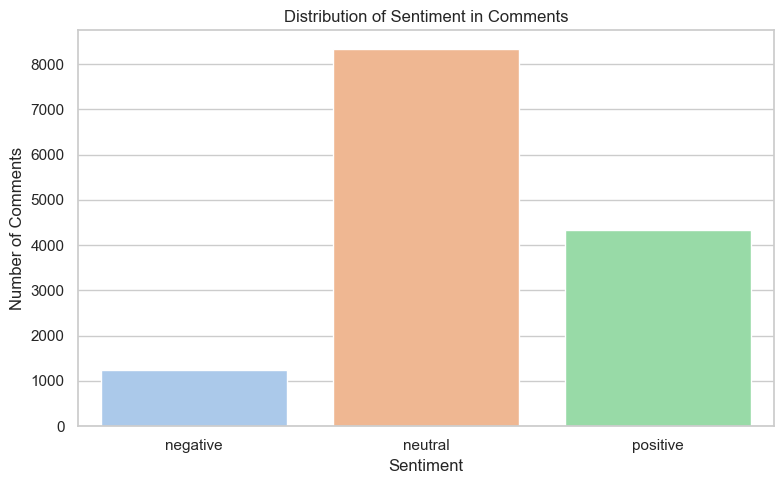

In [28]:
# 2. Plot: Like-to-View Ratio by Sentiment
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_stats, x='sentiment_label', y='avg_like_to_view', palette='Set2')
plt.title("Average Like-to-View Ratio by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Like-to-View Ratio")
plt.tight_layout()
plt.show()

# 3. Plot: Average Comment Length by Sentiment
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_stats, x='sentiment_label', y='avg_comment_length', palette='Set1')
plt.title("Average Comment Length by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Number of Words")
plt.tight_layout()
plt.show()

# 4. Plot: Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.barplot(data=sentiment_stats, x='sentiment_label', y='count', palette='pastel')
plt.title("Distribution of Sentiment in Comments")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.tight_layout()
plt.show()